# A suggestion of curse changes for a robot sailboat

## Motivation

The goal of this project is to suggest good points to change the curse of a sailboat while going from point $A$ to point $B$.

This project is done as part of the curse "Maschienen Learning" at the University of Applied Sciences South Westphalia. The code labeling the was writen by the team of the [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/). A society of stundens whose goal it is to build the ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) a fully autonomous sailboat able to cross the atlantic ocean. A technical challenge that was mastered the first time only a few years ago by [a Norwegian team](http://sailbuoy.no/). I myself am part of the Sailing Team Darmstadt e.V. for nearly 10 years.

One of the challenges to solve is a highly efficient way to find a path over the Ocean. The boot is only 2 meters long and powered by solar energy. That makes power a relatively spares commodity.

## Situation as is
At the moment the pathfinding algorithm generates a set of more or less random routes to the goal. Each route than gets optimized by a gradient decent moving the curse change points over the ocean to find a path with the lowest cost that can be found by following the highest gradient. This is relatively inefficient since only local minima can be found for each of the randomly generated route. The route with the lowest cost for the so optimized route will be chosen as the final route.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and therefore energy can be saved this way.
The idea of this project is to ascertain if it is possible to generate a better initial route through a neural network to give the system a kind of good instinct for the initial routes to reduce optimization steps and the number fo routes that need to be calculated to find a good route. Even tough the initial calculation effort could be high the parallel calculation of 40 routes and lots of optimization steps make it possible that some calculation time and energy can be saved this way.

## The Project

The goal of this project is to calculate a good first route. That allows for some simplifications of this problem.

Some solutions and assumptions can be made.
1. The route proposed by this network will not be the final route. This make a somewhat accurate solution good enough.
2. Since the neural network should not learn how to interpret a specific map but the concept of a map the map can be rotated.
This allows the wind to come always from north.
3. Since curse speed is only somewhat proportional to the wind speed a final course may change depending on wind speed not only direction.
These changes are however somewhat small compared to other influences and can hopefully be ignored since later processing of a proposed route should strait these details out.
4. When the wind comes always from the same direction (After map orientation by wind) map and route can be mirrored allowing to use all data twice for each route.
5. Scale does only matter when the curvature of the earth has a significant influence. Allowing for different scaling of the problem for additional training data.

Since there is a solution for this project that only needs some optimisation we can used labeled data to train the network.

### The generell structure

Since

In [1]:
%cd /pyrate/

In [2]:
import os
from typing import Optional, Final, Literal
from math import pi
import glob

from tqdm.notebook import trange, tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union, split
import mapply

In [3]:
import experiments
from pyrate.plan.nearplanner.timing_frame import TimingFrame
from pyrate.plan.geometry.route import CartesianRoute

In [4]:
mapply.init(n_workers=-1, chunk_size=100, max_chunks_per_worker=8, progressbar=True)

In [5]:
experiments.optimization_param.n_iter_grad = 50
experiments.optimization_param.verbose = False

In [6]:
SIZE_INNER: Final[int] = 75
SIZE_ROUTE: Final[int] = 100
MIN_DESTINATION_DISTANCE: Final[int] = 25
IMG_SIZE: Final[int] = SIZE_ROUTE * 2
IMG_SHOW_SIZE: Final[int] = 400

In [7]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    angles: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        angles: A array of angles.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * angles * np.pi)


def cartesian_to_polar(
    x: np.ndarray,
):
    """Transforms cartesian coordinates into polar coordinates.

    Args:
        x: A set of complex number to be separated into polar coordinates.

    Returns:
        An distance array and an angle array.
    """
    return abs(x), np.angle(x)

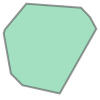

In [8]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    number_of_corners = np.random.randint(3, 10)
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)
    # return_values[1, :] = np.real(offset)
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)
    # return np.array( + offset[0], np.imag(array) + offset[1])


np.random.seed(42)
random_polygon()

In [9]:
def generate_obstacles(
    seed=None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    if seed is not None:
        np.random.seed(seed)
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        polygons.append(poly)
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

In [10]:
def generate_destination(
    obstacles: dict[str, Polygon],
    seed: Optional[int] = None,
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


  0%|          | 0/12 [00:00<?, ?it/s]

/pyrate/pyrate/plan/nearplanner/cost_functions.py:131: RuntimeWarning: overflow encountered in double_scalars
  grad = -cost * self.scale * self.safety_dist / dist**2 if dist > 0 else 0


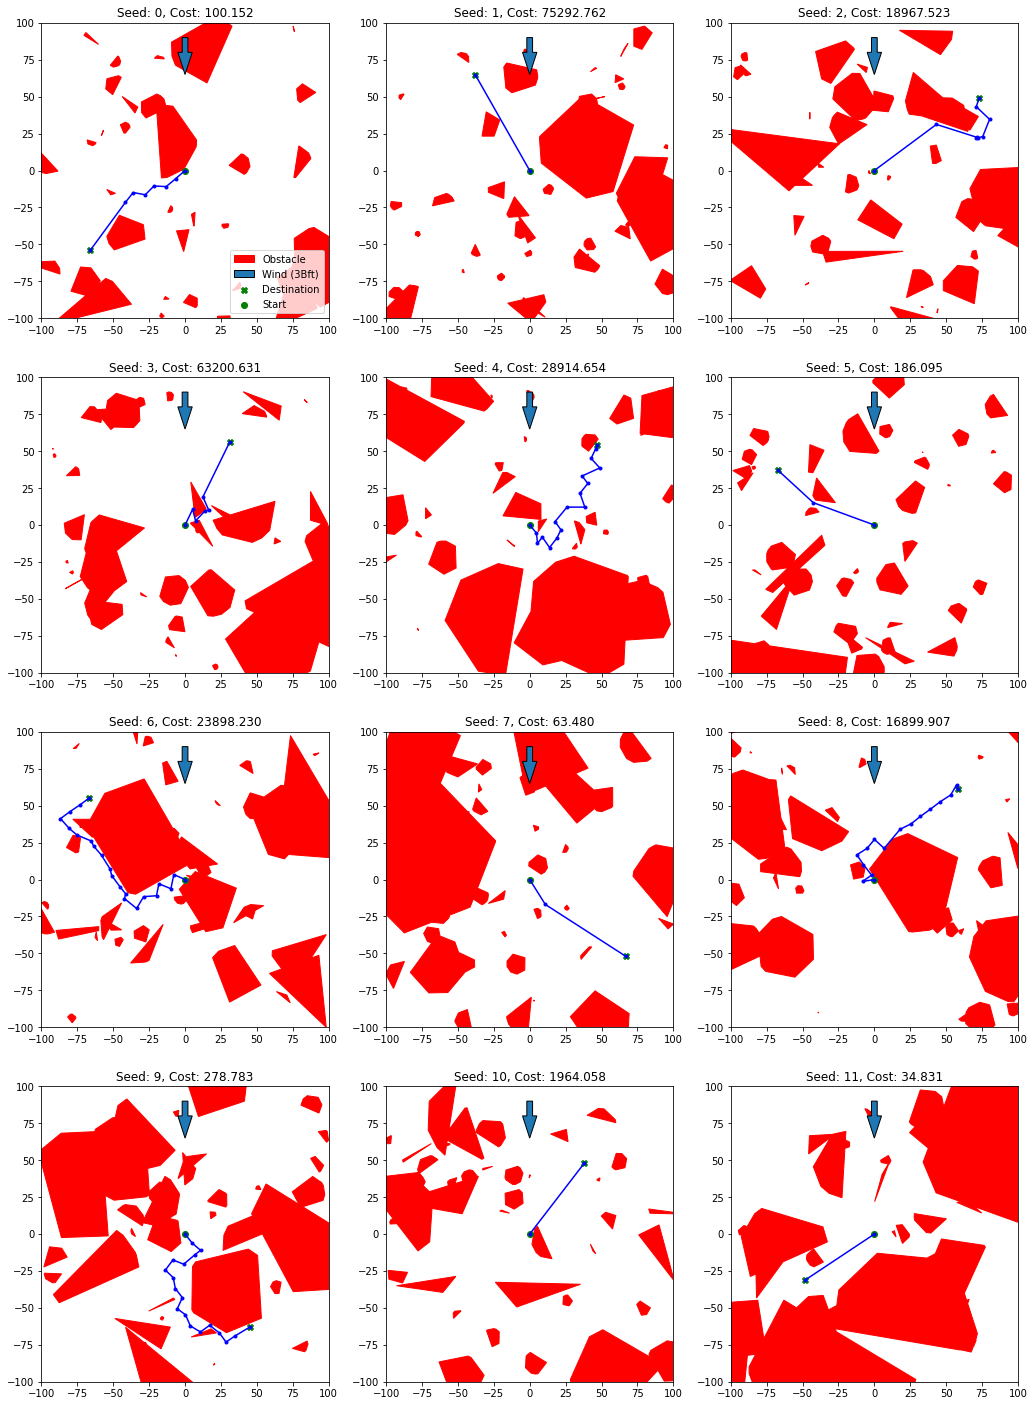

In [11]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: str | None = None,
    route: TimingFrame | np.ndarray | None = None,
    legend: bool = True,
    title: str | None = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    # x.figure(figsize=(8, 8))
    # plt.axis([70.9481331655341 - 5, 70.9481331655341 + 5,  43.24219045432384-5, 43.24219045432384+5])
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obsticles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route is not None:
        if isinstance(route, TimingFrame):
            plt.plot(route.points[:, 0], route.points[:, 1], color="BLUE", marker=".")
        elif isinstance(route, np.ndarray):
            plt.plot(route[:, 0], route[:, 1], color="BLUE", marker=".")
        else:
            raise TypeError()

    # Plots the estination
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    return None


plt.figure(figsize=(17.5, 25))
for seed in tqdm(range(12)):
    plt.subplot(4, 3, seed + 1)
    wind_dir = 180
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)
    route = None
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        route = None
    plot_situation(
        obstacles=obstacles,
        destination=destination,
        obstacle_color="RED",
        route=route,
        title=f"Seed: {seed}, Cost: {route.cost:.3f}",
        legend=seed == 0,
    )
plt.show()

In [12]:
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route_type: Literal["line", "dot"],
    route: np.ndarray | TimingFrame | None = None,
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
    """
    img = Image.new(
        "RGB",
        (IMG_SIZE, IMG_SIZE),
        "#ffffff",
    )
    draw = ImageDraw.Draw(img)
    for polygon in obstacles.values():
        draw.polygon(
            list(np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE),
            fill="#FF0000",
            outline="#FF0000",
        )
    if isinstance(route, TimingFrame):
        route = route.points
    route = route + 100
    if route_type == "line":
        draw.line([tuple(point) for point in route], fill=(0, 0, 0xFF))
    elif route_type == "dot":
        for point in route.round().astype(int):
            img.putpixel(point, (0, 0, 0xFF))
        pass
    else:
        raise ValueError("Route type unknown.")
    img.putpixel((int(destination.x) + 100, int(destination.y) + 100), (0, 0xFF, 0))
    return img


def generate_example_image(route_type: Literal["line", "dot"]):
    seed = 42
    wind_dir = 180
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)
    route = None
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        route = None
    return generate_image_from_map(
        obstacles=obstacles,
        destination=destination,
        route=route,
        route_type=route_type,
    )

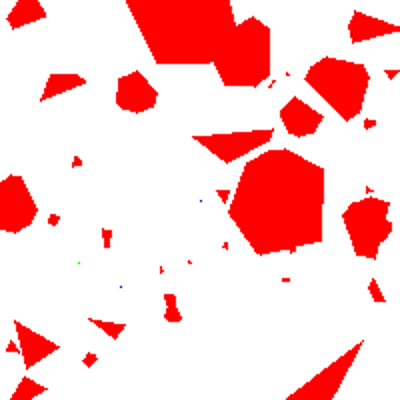

In [13]:
generate_example_image(route_type="dot").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
).show()

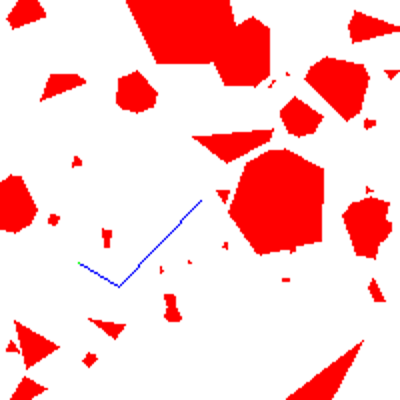

In [14]:
generate_example_image(route_type="line").resize(
    (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
).show()

In [15]:
seed = 42
wind_dir = 180
obstacles = generate_obstacles(seed)
destination = generate_destination(obstacles, seed)
route = None
route, _ = experiments.generate_route(
    position=Point(0, 0),
    goal=destination,
    obstacles=obstacles,
    wind=(18, wind_dir),
)

  0%|          | 0/1 [00:00<?, ?it/s]

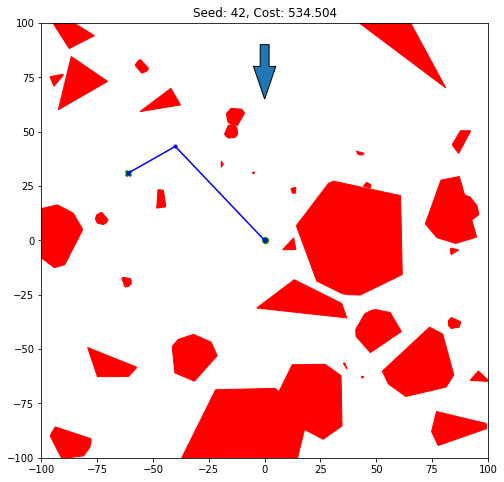

In [16]:
for seed in tqdm([42]):
    plt.figure(figsize=(8, 8))
    wind_dir = 180
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)
    route = None
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        route = None
    plot_situation(
        obstacles=obstacles,
        destination=destination,
        obstacle_color="RED",
        route=route,
        title=f"Seed: {seed}, Cost: {route.cost:.3f}",
        legend=seed == 0,
    )
    plt.show()

In [17]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)

    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        print(e)
        route = None
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

In [18]:
df = pd.DataFrame(
    [generate_all_to_series(i, image=False) for i in tqdm(range(2))]
).set_index("seed")
df.to_pickle("test.pickle")
df

  0%|          | 0/2 [00:00<?, ?it/s]

obstacles  destination_x  \
seed                                                                     
0     {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1     {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   

      destination_y image                                              route  \
seed                                                                           
0             -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1              65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   

              cost  
seed                
0       100.151629  
1     75292.761936

https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/)
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask

```python
save_frequency = int(os.getenv("save_frequency", "50"))
start_seed = int(os.getenv("seed_start", "0"))
continues = bool(os.getenv("continues", "false"))

files = glob.glob("data/*.pickle")
seed_groups = {int(file[9:-7]) for file in files}
for next_seeds in range(start_seed, 10_000_000_000, save_frequency):
    if next_seeds in seed_groups:
        continue
    print(f"Start generating routes for seed: {next_seeds}")
    tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
    pd.DataFrame().to_pickle(tmp_pickle_str)
    df = pd.DataFrame(
        [
            generate_all_to_series(i, image=False)
            for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
        ]
    ).set_index("seed")
    pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
    df.to_pickle(pickle_to_file)
    os.remove(tmp_pickle_str)
    if not continues:
        break
```

In [19]:
DATA_COLECTION_PATH = "data/collected.pickle"
if os.path.exists(DATA_COLECTION_PATH):
    collected_data = pd.read_pickle(DATA_COLECTION_PATH)
else:
    collected_data = pd.concat(
        [pd.read_pickle(filename) for filename in tqdm(glob.glob("data/raw_*.pickle"))]
    )
    number_of_maps = len(collected_data.index)
    print(f"{number_of_maps: 10} maps collected")
    collected_data.dropna(subset=["route"], inplace=True)
    number_of_routes = len(collected_data.index)
    print(f"{number_of_routes: 10} routes collected")
    collected_data.to_pickle(DATA_COLECTION_PATH)
collected_data

  0%|          | 0/2668 [00:00<?, ?it/s]

    133400 maps collected
    120446 routes collected


obstacles  destination_x  \
seed                                                                       
0       {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1       {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2       {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3       {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4       {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
...                                                   ...            ...   
133445  {'0': POLYGON ((-4.444500832239974 -101.105815...          -63.0   
133446  {'0': POLYGON ((-50.18524806320142 -94.6903944...          -44.0   
133447  {'0': POLYGON ((-15.11578684131388 -83.2968281...           60.0   
133448  {'0': POLYGON ((-40.190401796991324 -82.393980...           40.0   
133449  {'0': POLYGON ((-36.69132405456605 -97.9877273...          -30.0   

        destination_y image  \
seed                          
0               -54.0  <NA>   
1                65.0  <NA>   
2                49.0  <NA>   
3                56.0  <NA>   
4                54.0  <NA>   
...               ...   ...   
133445           28.0  <NA>   
133446          -65.0  <NA>   
133447          -27.0  <NA>   
133448           46.0  <NA>   
133449          -66.0  <NA>   

                                                    route          cost  
seed                                                                     
0       [[0.0, 0.0], [-6.514627334268863, -5.502693040...    100.151629  
1                             [[0.0, 0.0], [-38.0, 65.0]]  75292.761936  
2       [[0.0, 0.0], [43.20648551245758, 31.2114102262...  18967.522925  
3       [[0.0, 0.0], [5.303962239032221, 10.6856391688...  63200.630758  
4       [[0.0, 0.0], [4.691900284503645, -5.4114328014...  28914.654143  
...                                                   ...           ...  
133445                        [[0.0, 0.0], [-63.0, 28.0]]     83.316185  
133446                       [[0.0, 0.0], [-44.0, -65.0]]     50.032302  
133447  [[0.0, 0.0], [5.224296002931534, -3.9995913883...    263.430207  
133448                         [[0.0, 0.0], [40.0, 46.0]]    785.893562  
133449  [[0.0, 0.0], [-2.7740483244056953, -6.60226117...    120.022162  

[120446 rows x 6 columns]

# find and drop all routes that exit the map!

In [20]:
def check_route_in_bounds(route):

    # easier to debut in multiple lines
    if route is None:
        return False
    if route is pd.NA:
        return False
    if not isinstance(route, np.ndarray):
        return False
    if np.array(
        abs(route) > 100,
    ).any():
        return False
    return True


data_before = len(collected_data.index)

df_filter = collected_data["route"].mapply(check_route_in_bounds)
filtered = collected_data[~df_filter]
collected_data = collected_data[df_filter]

data_after = len(collected_data.index)

print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)
del data_before, data_after
filtered

  0%|          | 0/72 [00:00<?, ?it/s]

120446 - 542 = 119904 sets of data remaining.


obstacles  destination_x  \
seed                                                                       
28      {'0': POLYGON ((-79.19430592183373 -49.2547523...          -74.0   
288     {'0': POLYGON ((-44.931306151516914 -95.541097...           68.0   
390     {'0': POLYGON ((-56.94613026317691 -86.1604982...          -60.0   
427     {'0': POLYGON ((-4.107753795465081 -85.5721111...          -65.0   
443     {'0': POLYGON ((-28.5553767564301 -13.94116836...          -57.0   
...                                                   ...            ...   
132727  {'0': POLYGON ((-7.984031435102791 -87.5340307...          -73.0   
132753  {'0': POLYGON ((2.9624246636150606 -99.4650021...           68.0   
132844  {'0': POLYGON ((-92.86419757197173 -96.0586227...          -71.0   
132949  {'0': POLYGON ((3.306510959750937 -84.76053956...          -53.0   
133160  {'0': POLYGON ((-26.146276709249783 -92.813408...          -72.0   

        destination_y image  \
seed                          
28              -70.0  <NA>   
288              65.0  <NA>   
390             -48.0  <NA>   
427             -60.0  <NA>   
443             -32.0  <NA>   
...               ...   ...   
132727           72.0  <NA>   
132753           32.0  <NA>   
132844           68.0  <NA>   
132949           73.0  <NA>   
133160          -55.0  <NA>   

                                                    route          cost  
seed                                                                     
28      [[0.0, 0.0], [0.7011646546083345, -10.16210451...  46695.546503  
288     [[0.0, 0.0], [52.841238026497464, 57.151140944...    908.105976  
390     [[0.0, 0.0], [3.1740647727139097, -9.016239845...  62476.439296  
427     [[0.0, 0.0], [-35.26727571107932, -32.33274441...  51429.594921  
443     [[0.0, 0.0], [-26.80256330110968, -4.965386176...   96004.14884  
...                                                   ...           ...  
132727  [[0.0, 0.0], [-4.500562847367333, -9.540504836...  79728.435665  
132753  [[0.0, 0.0], [22.53803703650179, 3.66799839781...    711.110756  
132844  [[0.0, 0.0], [-3.6298965550474294, 8.796817242...  59687.179116  
132949  [[0.0, 0.0], [-100.9203527809008, 95.352606668...    705.265287  
133160  [[0.0, 0.0], [6.406637183421581, 6.40663718342...    578.437288  

[542 rows x 6 columns]

# find and drop all routes with errors!


In [21]:
def check_route_self_crossing(route):
    if isinstance(route, float):
        print(float)
    return not LineString(route).is_simple


data_before = len(collected_data.index)
collected_data = collected_data[
    ~collected_data["route"].mapply(check_route_self_crossing)
]
data_after = len(collected_data.index)
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)
del data_before, data_after

  0%|          | 0/72 [00:00<?, ?it/s]

119904 - 3330 = 116574 sets of data remaining.


# distribution over costs and points in rutes routes!

In [22]:
QUNATILE_LIMIT: Final[float] = 0.95
if "DATA_UPPER_LIMIT_QUANTIL" not in locals():
    DATA_UPPER_LIMIT_QUANTIL: Final[float] = collected_data["cost"].quantile(
        QUNATILE_LIMIT
    )
    OVER_QUANTILE: Final[int] = int(len(collected_data.index) * (1 - QUNATILE_LIMIT))
print(
    f"{OVER_QUANTILE} entries over the {QUNATILE_LIMIT} quantile at {DATA_UPPER_LIMIT_QUANTIL:.3f}"
)

5828 entries over the 0.95 quantile at 40261.209


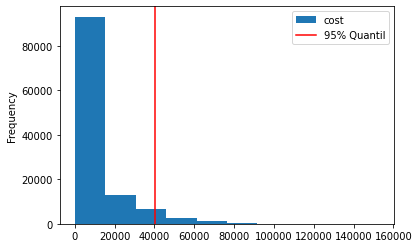

In [23]:
collected_data["cost"].plot.hist(bins=10, log=False)  # find a drop limit
plt.axvline(x=DATA_UPPER_LIMIT_QUANTIL, color="RED", label="95% Quantil")
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

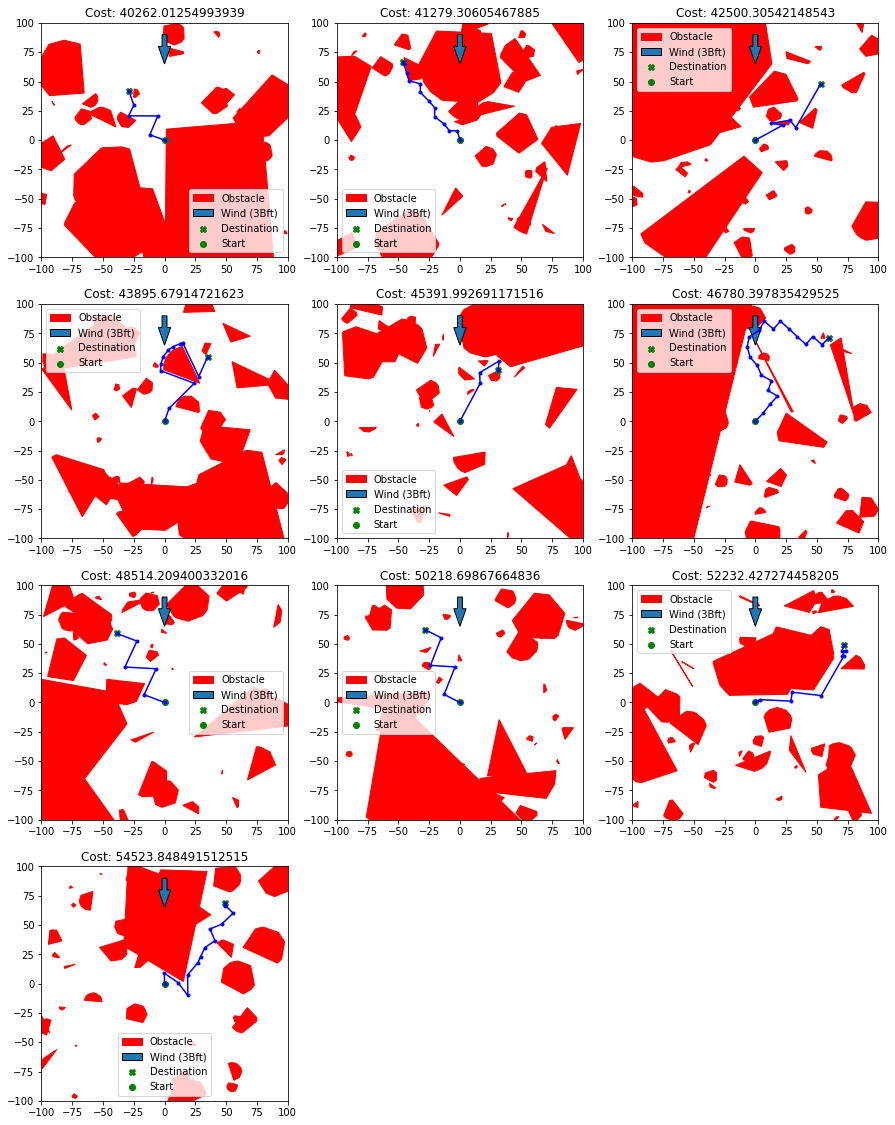

In [24]:
plt.figure(figsize=(15, 25))
for count, (seed, row) in tqdm(
    enumerate(
        collected_data[collected_data["cost"] > DATA_UPPER_LIMIT_QUANTIL]
        .sort_values("cost")
        .iloc[0 :: int(OVER_QUANTILE / 15)]
        .iloc[:10]
        .iterrows()
    ),
    total=10,
):
    plt.subplot(5, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost}",
    )
plt.show()

In [25]:
collected_data = collected_data.loc[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
collected_data

obstacles  destination_x  \
seed                                                                       
0       {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2       {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4       {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5       {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6       {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
...                                                   ...            ...   
133445  {'0': POLYGON ((-4.444500832239974 -101.105815...          -63.0   
133446  {'0': POLYGON ((-50.18524806320142 -94.6903944...          -44.0   
133447  {'0': POLYGON ((-15.11578684131388 -83.2968281...           60.0   
133448  {'0': POLYGON ((-40.190401796991324 -82.393980...           40.0   
133449  {'0': POLYGON ((-36.69132405456605 -97.9877273...          -30.0   

        destination_y image  \
seed                          
0               -54.0  <NA>   
2                49.0  <NA>   
4                54.0  <NA>   
5                37.0  <NA>   
6                55.0  <NA>   
...               ...   ...   
133445           28.0  <NA>   
133446          -65.0  <NA>   
133447          -27.0  <NA>   
133448           46.0  <NA>   
133449          -66.0  <NA>   

                                                    route          cost  
seed                                                                     
0       [[0.0, 0.0], [-6.514627334268863, -5.502693040...    100.151629  
2       [[0.0, 0.0], [43.20648551245758, 31.2114102262...  18967.522925  
4       [[0.0, 0.0], [4.691900284503645, -5.4114328014...  28914.654143  
5       [[0.0, 0.0], [-42.539218405821984, 15.14880405...    186.095369  
6       [[0.0, 0.0], [-7.80975254664349, 3.41866699781...  23898.229531  
...                                                   ...           ...  
133445                        [[0.0, 0.0], [-63.0, 28.0]]     83.316185  
133446                       [[0.0, 0.0], [-44.0, -65.0]]     50.032302  
133447  [[0.0, 0.0], [5.224296002931534, -3.9995913883...    263.430207  
133448                         [[0.0, 0.0], [40.0, 46.0]]    785.893562  
133449  [[0.0, 0.0], [-2.7740483244056953, -6.60226117...    120.022162  

[110745 rows x 6 columns]

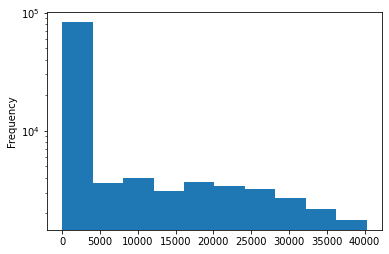

In [26]:
collected_data["cost"].plot.hist(log=True)
plt.show()

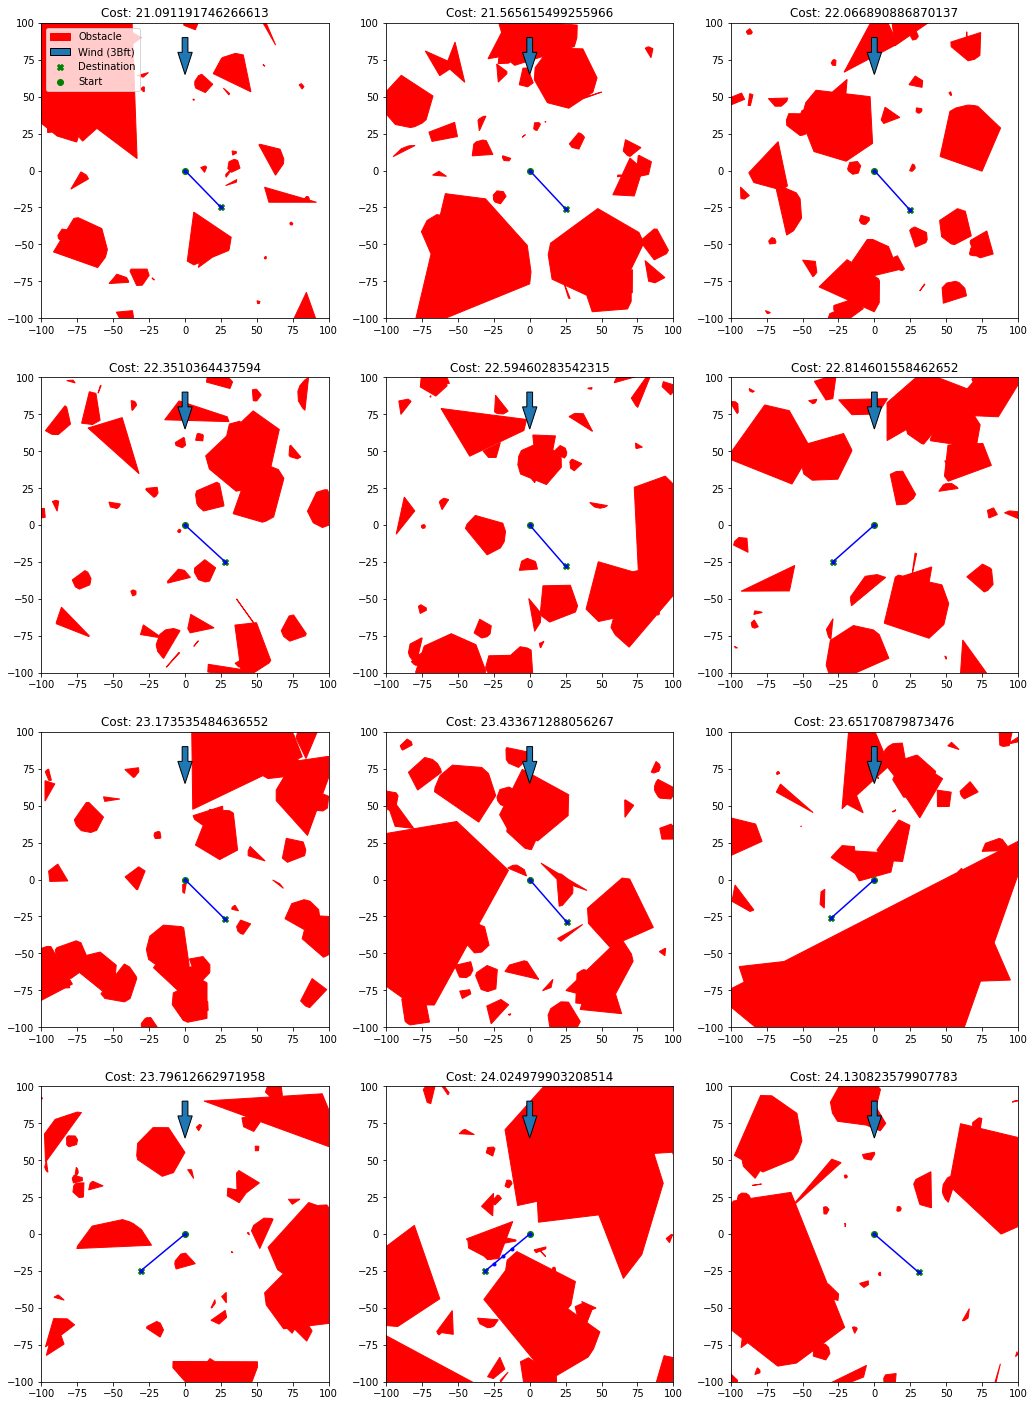

In [27]:
collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]

plt.figure(figsize=(17.5, 25))
for count, (seed, row) in enumerate(
    collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
    .sort_values("cost")
    .iloc[1:600:51]
    .iterrows()
):
    plt.subplot(4, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.obstacles,
        obstacle_color="RED",
        route=row.route,
        title=f"Cost: {row.cost}",
        legend=count == 0,
    )

plt.show()

# fisualize costs

In [28]:
collected_data

obstacles  destination_x  \
seed                                                                       
0       {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2       {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4       {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5       {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6       {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
...                                                   ...            ...   
133445  {'0': POLYGON ((-4.444500832239974 -101.105815...          -63.0   
133446  {'0': POLYGON ((-50.18524806320142 -94.6903944...          -44.0   
133447  {'0': POLYGON ((-15.11578684131388 -83.2968281...           60.0   
133448  {'0': POLYGON ((-40.190401796991324 -82.393980...           40.0   
133449  {'0': POLYGON ((-36.69132405456605 -97.9877273...          -30.0   

        destination_y image  \
seed                          
0               -54.0  <NA>   
2                49.0  <NA>   
4                54.0  <NA>   
5                37.0  <NA>   
6                55.0  <NA>   
...               ...   ...   
133445           28.0  <NA>   
133446          -65.0  <NA>   
133447          -27.0  <NA>   
133448           46.0  <NA>   
133449          -66.0  <NA>   

                                                    route          cost  
seed                                                                     
0       [[0.0, 0.0], [-6.514627334268863, -5.502693040...    100.151629  
2       [[0.0, 0.0], [43.20648551245758, 31.2114102262...  18967.522925  
4       [[0.0, 0.0], [4.691900284503645, -5.4114328014...  28914.654143  
5       [[0.0, 0.0], [-42.539218405821984, 15.14880405...    186.095369  
6       [[0.0, 0.0], [-7.80975254664349, 3.41866699781...  23898.229531  
...                                                   ...           ...  
133445                        [[0.0, 0.0], [-63.0, 28.0]]     83.316185  
133446                       [[0.0, 0.0], [-44.0, -65.0]]     50.032302  
133447  [[0.0, 0.0], [5.224296002931534, -3.9995913883...    263.430207  
133448                         [[0.0, 0.0], [40.0, 46.0]]    785.893562  
133449  [[0.0, 0.0], [-2.7740483244056953, -6.60226117...    120.022162  

[110745 rows x 6 columns]

In [29]:
def generate_image_maps(row):
    return (
        generate_image_from_map(
            obstacles=row.obstacles,
            destination=Point(row.destination_x, row.destination_y),
            route=row.route,
            route_type="dot",
        ),
        generate_image_from_map(
            obstacles=row.obstacles,
            destination=Point(row.destination_x, row.destination_y),
            route=row.route,
            route_type="line",
        ),
    )

In [30]:
collected_data["image_points"], collected_data["image_lines"] = collected_data.mapply(
    generate_image_maps, axis=1
)
collected_data

  0%|          | 0/72 [00:00<?, ?it/s]

IndexError: image index out of range

In [ ]:
DATA_WITH_IMG_PATH: Final[str] = "data/collectedWithImage.pickle"


def generate_image_maps(row):
    return generate_image_from_map(
        obstacles=row.obstacles,
        destination=Point(row.destination_x, row.destination_y),
        route=row.route,
    )


if os.path.exists(DATA_WITH_IMG_PATH):
    collected_data = pd.read_pickle(DATA_WITH_IMG_PATH)
else:
    (
        collected_data["image_points"],
        collected_data["image_lines"],
    ) = collected_data.mapply(generate_image_maps, axis=1)
    del collected_data["image"]
    collected_data.to_pickle(DATA_WITH_IMG_PATH)

In [ ]:
# pd.Series([1,2,3,4,5,6]).apply()

Ich würde auch zu 1. tendieren, stimme Ihnen aber zu, dass das Thema sehr umfangreich ist. Könnte man sich nicht einen Teilbereich herauspicken? Ich verstehe nicht viel vom Segeln, daher lassen Sie mich kurz zusammenfassen, was Sie vorhaben: - Sie generieren Trainingsdaten mit dem existierenden aber langsamen GD Algorithmus. Ich nehme an, es handelt sich um lokale Routen in einem relativ kleinen Kartenausschnitt. Lässt es die Laufzeit zu, dass Sie eine große Menge an Routen berechnen. - Sie haben dann eine Karte und als Ausgabe eine Liste der Wendepunkte - Warum wollen Sie daraus eine Heatmap berechnen? Diesen Schritt habe ich noch nicht verstanden - Wenn Sie aus einer Karte eine Heatmap trainieren wollen und dafür genügend Beispiele haben, könnnten GANs hilfreich sein: https://arxiv.org/abs/1611.07004 Ich würde Ihnen raten, das Problem möglichst so zu reduzieren, dass es im Rahmen des Moduls noch handhabbar bleibt. Alles Weitere kann man sich auch für spätere Arbeiten aufbewahren. Das 2. Thema ist auch ok. Aber vielleicht nicht ganz so spannend. Ich überlasse Ihnen die Entscheidung. Freundliche Grüße Heiner Giefers

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
xs = np.linspace(-1, 1)
plt.subplot(2, 2, 1)
plt.plot(xs, np.sin(xs))
plt.subplot(2, 2, 2)
plt.plot(xs, np.cos(xs))
plt.subplot(2, 2, 3)
plt.plot(xs, np.tan(xs))
plt.subplot(2, 2, 4)
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(5, 5))

In [ ]:
# better next time
Min distance zwischen ziel und hindernis einfügen